In [34]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, confusion_matrix, classification_report
import xgboost as xgb


In [35]:
# Load data from CSV files
train = pd.read_csv('UCI HAR dataset/csv_files/train.csv')
test = pd.read_csv('UCI HAR dataset/csv_files/test.csv')

print(train.shape, test.shape)

X_train = train.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_train = train.ActivityName

X_test = test.drop(['subject', 'Activity', 'ActivityName'], axis=1)
y_test = test.ActivityName

print('X_train and y_train : ({},{})'.format(X_train.shape, y_train.shape))
print('X_test  and y_test  : ({},{})'.format(X_test.shape, y_test.shape))
# Encode target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)


(7352, 564) (2947, 564)
X_train and y_train : ((7352, 561),(7352,))
X_test  and y_test  : ((2947, 561),(2947,))


In [36]:
# Step 1: Analyze Redundant Features
corr_matrix = X_train.corr()
high_corr_features = set()

for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            feature_name = corr_matrix.columns[i]
            high_corr_features.add(feature_name)

print(f"Number of highly correlated features: {len(high_corr_features)}")

X_train_reduced = X_train.drop(columns=high_corr_features)
X_test_reduced = X_test.drop(columns=high_corr_features)


Number of highly correlated features: 359


In [37]:
# Step 2: Dimensionality Reduction with PCA
pca = PCA(n_components=0.95)
X_train_pca = pca.fit_transform(X_train_reduced)
X_test_pca = pca.transform(X_test_reduced)

print(f"Reduced dimensions using PCA: {X_train_pca.shape[1]}")


Reduced dimensions using PCA: 91


In [38]:
# Step 3: Feature Selection with SelectKBest
kbest = SelectKBest(score_func=f_classif, k=50)
X_train_kbest = kbest.fit_transform(X_train_reduced, y_train)
X_test_kbest = kbest.transform(X_test_reduced)

print(f"Reduced dimensions using SelectKBest: {X_train_kbest.shape[1]}")


Reduced dimensions using SelectKBest: 50


In [45]:
# Model Training and Comparison
results = {}

for feature_set_name, (X_tr, X_te) in {
    "PCA": (X_train_pca, X_test_pca),
    "KBest": (X_train_kbest, X_test_kbest)
}.items():
    for name, (model, param_grid) in {
        'Logistic Regression': (LogisticRegression(max_iter=1000), {'C': [0.01, 0.1, 1, 10]}),
        'K-Nearest Neighbors': (KNeighborsClassifier(), {'n_neighbors': [3, 5, 7, 9]}),
        'Random Forest': (RandomForestClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'max_depth': [None, 10, 20, 30]}),
        'Support Vector Machine': (SVC(), {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'], 'kernel': ['linear', 'poly', 'rbf']}),
        'XGBoost': (xgb.XGBClassifier(random_state=42), {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]}),
    }.items():
        grid = GridSearchCV(model, param_grid, cv=5, n_jobs=-1, verbose=1)
        grid.fit(X_tr, y_train)
        best_model = grid.best_estimator_

        y_pred_train = best_model.predict(X_tr)
        y_pred_test = best_model.predict(X_te)

        train_acc = accuracy_score(y_train, y_pred_train)
        test_acc = accuracy_score(y_test, y_pred_test)

        results[f"{feature_set_name} - {name}"] = {
    'Best Params': grid.best_params_,
    'Train Accuracy': train_acc,
    'Test Accuracy': test_acc,
    'Best Model': best_model  
}

# Display results
print("Model Results:")
for model_name, result in results.items():
    print(f"{model_name}: {result}")

# Compare Feature Sets
pca_results = {k: v for k, v in results.items() if k.startswith("PCA")}
kbest_results = {k: v for k, v in results.items() if k.startswith("KBest")}

best_pca_model = max(pca_results, key=lambda x: pca_results[x]['Test Accuracy'])
best_kbest_model = max(kbest_results, key=lambda x: kbest_results[x]['Test Accuracy'])

print("\nBest PCA Model:")
print(best_pca_model, pca_results[best_pca_model])

print("\nBest KBest Model:")
print(best_kbest_model, kbest_results[best_kbest_model])


Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Model Results:
PCA - Logistic Regression: {'Best Params': {'C': 1}, 'Train Accuracy': 0.9733405875952121, 'Test Accuracy': 0.9412962334577536, 'Best Model': LogisticRegression(C=1, max_iter=1000)}
PCA - K-Nearest Neighbors: {'Best Params': {'n_neighbors': 9}, 'Train Accuracy': 0.9674918389553863, 'Test Accuracy': 0.8788598574821853, 'Best Model': KNeighborsClassifier(n_neighbors=9)}
PCA - 

Classification Report for best pca model (SVC(C=10)):
              precision    recall  f1-score   support

           W       1.00      1.00      1.00       537
          WU       0.94      0.92      0.93       491
          WD       0.93      0.94      0.94       532
          SI       0.96      0.99      0.97       496
          ST       0.96      0.95      0.96       420
           L       0.96      0.93      0.94       471

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947



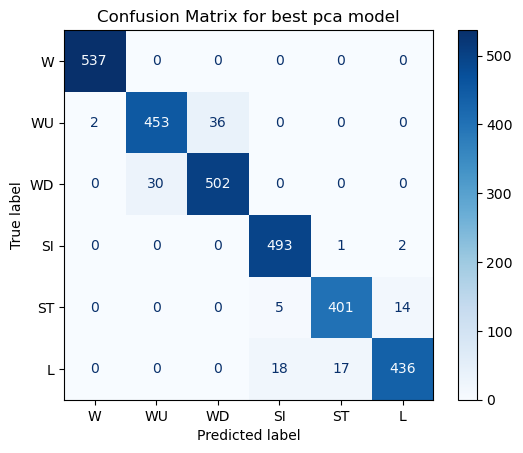

Cross-validation scores for best pca model: [0.91638341 0.89802855 0.92789116 0.95986395 0.95714286]
Mean cross-validation score for best pca model: 0.9318619847667142
Classification Report for best Kbest model (SVC(C=10)):
              precision    recall  f1-score   support

           W       1.00      1.00      1.00       537
          WU       0.88      0.76      0.81       491
          WD       0.80      0.90      0.85       532
          SI       0.76      0.96      0.85       496
          ST       0.95      0.78      0.86       420
           L       0.90      0.79      0.84       471

    accuracy                           0.87      2947
   macro avg       0.88      0.86      0.87      2947
weighted avg       0.88      0.87      0.87      2947



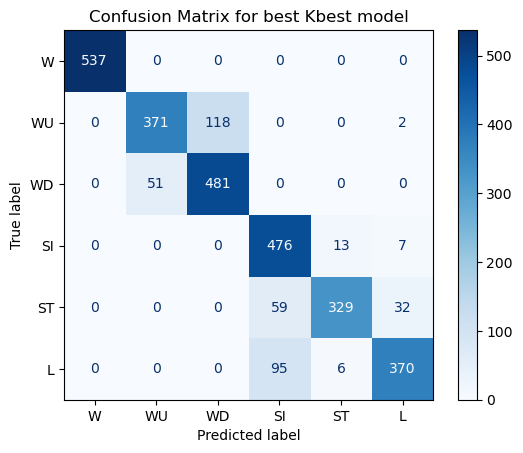

Cross-validation scores for best Kbest model: [0.87967369 0.85384092 0.88435374 0.88027211 0.92653061]
Mean cross-validation score for best Kbest model: 0.8849342156985159


In [48]:
best_pca_model_obj = pca_results[best_pca_model]['Best Model']
best_kbest_model_obj = kbest_results[best_kbest_model]['Best Model']
ACTIVITIES = {
    1: 'W',
    2: 'WU',
    3: 'WD',
    4: 'SI',
    5: 'ST',
    6: 'L',
}

print(f"Classification Report for best pca model ({best_pca_model_obj}):")
print(classification_report(y_test, best_pca_model_obj.predict(X_test_pca), target_names=ACTIVITIES.values()))


cm = confusion_matrix(y_test, best_pca_model_obj.predict(X_test_pca))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ACTIVITIES.values())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for best pca model")
plt.show()

cv_scores = cross_val_score(best_pca_model_obj, X_train_pca, y_train, cv=5)
print(f"Cross-validation scores for best pca model: {cv_scores}")
print(f"Mean cross-validation score for best pca model: {cv_scores.mean()}")

print(f"Classification Report for best Kbest model ({best_kbest_model_obj}):")
print(classification_report(y_test, best_kbest_model_obj.predict(X_test_kbest), target_names=ACTIVITIES.values()))


cm = confusion_matrix(y_test, best_kbest_model_obj.predict(X_test_kbest))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=ACTIVITIES.values())
disp.plot(cmap='Blues')
plt.title("Confusion Matrix for best Kbest model")
plt.show()

cv_scores = cross_val_score(best_kbest_model_obj, X_train_kbest, y_train, cv=5)
print(f"Cross-validation scores for best Kbest model: {cv_scores}")
print(f"Mean cross-validation score for best Kbest model: {cv_scores.mean()}")
